In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from sklearn.model_selection import train_test_split
import pandas as pd
# import tensorflow as tf
# import tensorflow_hub as hub
from datetime import datetime
import sys

In [35]:
import string

In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce RTX 3080'

In [18]:
data_file = './data/arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line


titles = []
abstracts = []
# years = []
# paper_dicts = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
#     paper_dicts.append(paper_dict)
#     abstract[0].translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('\n', ' '))
    titles.append(paper_dict.get('title').translate(str.maketrans('\n', ' ')))
    abstracts.append(paper_dict.get('abstract').translate(str.maketrans('\n', ' ')))
    
papers = pd.DataFrame({
    'title': titles,
    'abstract': abstracts
})
del titles
del abstracts

papers_small = papers.sample(n=100000, random_state=100)
papers.to_csv('./data/papers.csv')
papers_small.to_csv('./data/papers_small.csv')

In [87]:
papers['title'][0]

'Calculation of prompt diphoton production cross sections at Tevatron and   LHC energies'

In [41]:
len(papers.index)

1796911

## Length of tokens
Bert limits the length of input tokens to be 512 maximum. Here we'll have a look at the length of abstract tokens and title tokens.

In [21]:
import pickle

In [27]:
abst = [ab for ab in papers_small['abstract'].values]
titl = list(papers_small['title'].values)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

titl_tokens = [tokenizer.tokenize(t) for t in titl]
# saving title tokens
output = open('./data/ttl_tokens_small.pkl', 'wb')
pickle.dump(titl_tokens, output)
output.close()

abst_tokens = [tokenizer.tokenize(ab) for ab in abst]
# saving abstract tokens
output = open('./data/abs_tokens_small.pkl', 'wb')
pickle.dump(abst_tokens, output)
output.close()


In [30]:
length_abs = list(map(len, abst_tokens))
length_ttl = list(map(len, titl_tokens))
print('Abstract tokens:')
print('   Min length: {:,} tokens'.format(np.min(length_abs)))
print('   Max length: {:,} tokens'.format(np.max(length_abs)))
print('Median length: {:,} tokens'.format(np.median(length_abs)))
print()
print('Title tokens:')
print('   Min length: {:,} tokens'.format(np.min(length_ttl)))
print('   Max length: {:,} tokens'.format(np.max(length_ttl)))
print('Median length: {:,} tokens'.format(np.median(length_ttl)))

Abstract tokens:
   Min length: 3 tokens
   Max length: 1,595 tokens
Median length: 178.0 tokens

Title tokens:
   Min length: 1 tokens
   Max length: 103 tokens
Median length: 14.0 tokens


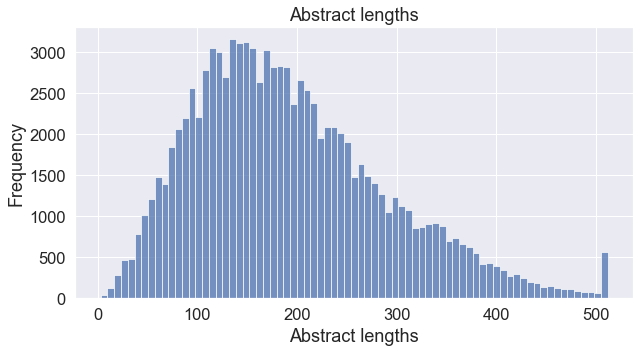

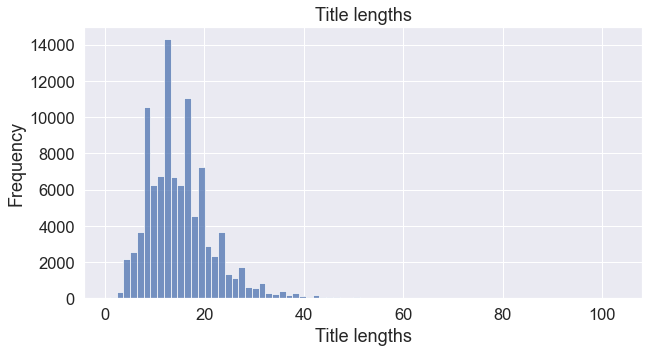

In [43]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10, 5)

# truncate length longer than 512
length_abs = [min(x, 512) for x in length_abs]

sns.histplot(length_abs, bins=75)
plt.title('Abstract lengths')
plt.xlabel('Abstract lengths')
plt.ylabel('Frequency')
plt.show()

sns.histplot(length_ttl, bins=75)
plt.title('Title lengths')
plt.xlabel('Title lengths')
plt.ylabel('Frequency')
plt.show()

## Preprocessing

In [5]:
X = ["[CLS] " + ab for ab in papers_small['abstract'].values]
y = papers_small['title'].values


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
X = [tokenizer.tokenize(ab) for ab in X]
y = [tokenizer.tokenize(t) for t in y]
print ("Tokenize the first abstract:")
print (X[0])

Tokenize the first abstract:
['[CLS]', 're', '##lat', '##ivist', '##ic', 'and', 'non', '-', 're', '##lat', '##ivist', '##ic', 'fluid', 'equations', 'can', 'exhibit', 'finite', 'time', 'singular', 'solutions', 'including', 'density', 'singular', '##ities', 'appearing', 'in', 'collapse', 'or', 'compression', 'systems', 'and', 'gradient', 'singular', '##ities', 'in', 'shock', 'waves', '.', 'however', ',', 'only', 'the', 'non', '-', 're', '##lat', '##ivist', '##ic', 'fluid', 'equations', 'have', 'been', 'shown', 'to', 'exhibit', 'finite', '-', 'time', 'velocity', 'singular', '##ities', ',', 'v', 'tending', 'to', 'infinity', 'in', 'this', 'regime', '.', 'as', 'this', 'limit', 'violate', '##s', 'the', 'cosmic', 'speed', 'limit', 'v', '<', 'c', ',', 'where', 'c', 'is', 'the', 'speed', 'of', 'light', ',', 'it', 'is', 'unclear', 'how', 'velocity', 'singular', '##ity', 'source', 'terms', 'in', 'the', 'non', '-', 're', '##lat', '##ivist', '##ic', 'equations', 'are', 'modified', 'in', 'the', 're',

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=12)

In [12]:
np.max(list(map(len, X_train)))

772

### Padding

In [8]:
# Set the maximum sequence length. 
MAX_LEN = 800
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in X_train],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in X_train]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (556 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (564 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (607 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (552 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (732 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (549 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (630 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (555 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (575 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (543 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [51]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

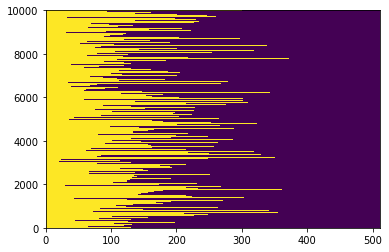

In [53]:
plt.pcolormesh(attention_masks)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)